# Cost Living and AFL Scenarios

note: need to run `kubectl port-forward svc/router 8888:80 -n fission` in terminal

In [1]:
import requests, pandas as pd, matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, Dropdown
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import warnings
from collections import Counter, defaultdict

In [2]:
# kubectl port-forward svc/router 8888:80 -n fission
BASE_URL = "http://127.0.0.1:8888/data-filter"

In [3]:
def post_processing(payload):
    resp = requests.post(BASE_URL, json=payload, timeout=120)
    resp.raise_for_status()
    
    data = resp.json()
    print("Total hits:", data["total"])
    
    docs = resp.json()["data"]
    records = []
    for d in docs:
        record = {
            "sentiment": d.get("sentiment"),
            "platform": d.get("platform"),
            "_id": d.get("_id"),
            "sentimentLabel": d.get("sentimentLabel"),
            "keywords": d.get("keywords"),
            "tags": d.get("data", {}).get("tags"),
            "createdAt": d.get("data", {}).get("createdAt"),
        }
        records.append(record)
    df = pd.DataFrame(records)
    
    df["createdAt"] = df["createdAt"].str.replace(r"Z$", "", regex=True)
    df["createdAt"] = pd.to_datetime(
        df["createdAt"],
        utc=True,
        errors="raise",
        format="ISO8601"
    )
    
    df["month"] = (
        df["createdAt"]
          .dt.tz_convert(None)
          .dt.to_period("M")
    )
    
    return df

# Cost Living

In [4]:
cost_living_payload = {
    "content": [
        "cost", "rent", "price", "grocery", "transport", "bill", "living", "wage", "income", "expensive",
        "afford", "renting", "apartment", "real estate", "landlord", "tenant", "lease", "mortgage", "housing",
        "electricity", "gas", "water", "utility", "power bill", "food", "meal", "dining", "supermarket", "shopping",
        "financial", "budget", "ripoff", "overpriced", "cheapest", "cheaper", "cheap", "struggle", "student loan",
        "university", "school", "tuition", "doctor", "hospital", "medicare", "insurance", "healthcare", "uber", "loan",
        "fee", "fees", "wws", "woolworths", "aldi", "coles", "buy", "pay", "myki", "PTV", "metro",
        "taxi", "public transport", "car", "petrol", "fuel"],
    "tags":     [],
    "keywords": ["brisbane", "melbourne", "sydney", "canberra", "adelaide", "perth", "hobart", "darwin"],
    "combine":  "and",
    "size":     10000,
    "max_docs": 500000,
    "date_range": {
        "from": "01-01-2023",
        "to":   "31-12-2026"
    }
}

cost_living_df = post_processing(cost_living_payload)

cities = ["brisbane", "melbourne", "sydney", "canberra", "adelaide", "perth", "hobart", "darwin"]
cost_living_df["city"] = cost_living_df["keywords"].apply(
    lambda kws: [c for c in cities if c in kws] if isinstance(kws, list) else []
)

cost_living_df = cost_living_df.explode("city")
cost_living_df = cost_living_df[cost_living_df["city"].notna()]

# functions 1
def show_avg_by_city():
    cities = ["brisbane", "melbourne", "sydney", "canberra", "adelaide", "perth", "hobart", "darwin"]
    df_exp = cost_living_df.explode("keywords")
    df_cities = df_exp[df_exp["keywords"].isin(cities)]
    avg_sent = (
        df_cities
        .groupby("keywords")["sentiment"]
        .mean()
        .reindex(cities)
        .sort_values(ascending=False)
    )
    
    plt.figure(figsize=(8, 5))
    avg_sent.plot(kind="bar", edgecolor="k")
    plt.title("Average Sentiment by City Keyword")
    plt.xlabel("City")
    plt.ylabel("Average Sentiment")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# function 2
def interact_city_month():
    df_tags = cost_living_df.explode("keywords").copy()
    df_tags["keywords_lower"] = df_tags["keywords"].astype(str).str.lower()
    
    cities = ["brisbane", "melbourne", "sydney", "canberra", "adelaide", "perth", "hobart", "darwin"]
    city1_dd = Dropdown(options=cities, value='brisbane', description='City 1:')
    city2_dd = Dropdown(options=cities, value='melbourne', description='City 2:')
    
    @interact(city1=city1_dd, city2=city2_dd)
    def plot_two(city1, city2):
        if city1 == city2:
            print("Please Select two different cities")
            return
    
        df_city_1  = df_tags[df_tags["keywords_lower"] == city1]
        df_city_2  = df_tags[df_tags["keywords_lower"] == city2]
    
        city_monthly_1 = (
            df_city_1
            .groupby("month")["sentiment"]
            .mean()
            .reset_index(name="avg_sentiment")
            .rename(columns={'avg_sentiment': city1})
        )
        city_monthly_2 = (
            df_city_2
            .groupby("month")["sentiment"]
            .mean()
            .reset_index(name="avg_sentiment")
            .rename(columns={'avg_sentiment': city2})
        )
    
        df_plot = (
            city_monthly_1
            .merge(city_monthly_2, on='month', how='outer')
            .sort_values('month')
            .reset_index(drop=True)
        )
    
        x     = np.arange(len(df_plot))
        width = 0.35
    
        fig, ax = plt.subplots(figsize=(9, 4))
        ax.bar(x - width/2, df_plot[city1],  width, label=city1)
        ax.bar(x + width/2, df_plot[city2],  width, label=city2)
    
        ax.set_xlabel('Month')
        ax.set_ylabel('Average sentiment')
        ax.set_title('Monthly average sentiment by city')
        ax.set_xticks(x)
        ax.set_xticklabels(df_plot['month'].astype(str), rotation=45, ha='right')
        ax.legend()
        plt.tight_layout()
        plt.show()

# function 3
def key_cloud():
    all_kw = cost_living_df["keywords"].explode().astype(str).str.lower()
    freq = all_kw.value_counts().to_dict()
    custom_stop = {
        "brisbane","melbourne","sydney","perth","adelaide",
        "removed","deleted","remove",
        "day","week","month","year","today","time",
        "good","people","things","work","living","buy","move",
        "hey","nt","n’t","ve","ll",
        "north","south","east","west", "australia", "'ve", "'re"
    }
    stopwords = set(STOPWORDS) | custom_stop
    freq = {w:c for w,c in freq.items() if w not in stopwords}
    
    wc = WordCloud(
        width=800, height=400,
        background_color="white",
        max_words=150,
        collocations=False
    ).generate_from_frequencies(freq)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Function 4: The distribution of Average Sentiment among Cities in Different Years
def show_violin_city_by_time():
    # Hide warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Select the time range
    def plot_sentiment(time_range):
        ranges = {
            "2023-2024": (cost_living_df["createdAt"] >= pd.Timestamp("2023-01-01", tz="UTC")) & 
                        (cost_living_df["createdAt"] < pd.Timestamp("2024-01-01", tz="UTC")),
            "2024–2025": (cost_living_df["createdAt"] >= pd.Timestamp("2024-01-01", tz="UTC")) & 
                        (cost_living_df["createdAt"] < pd.Timestamp("2025-01-01", tz="UTC")),
            "2025-Now": cost_living_df["createdAt"] >= pd.Timestamp("2025-01-01", tz="UTC"),
            "All Time": slice(None)
        }
        mask = ranges[time_range]
        filtered = cost_living_df[mask] if isinstance(mask, pd.Series) else cost_living_df.copy()

        # Consider if there's no data
        if filtered.empty:
            print("No data in this time range.")
            return

        # Calculate the average sentiment
        avg = filtered.groupby("city")["sentiment"].mean().sort_values(ascending=False).reset_index()
        city_order = avg["city"]

        # Plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(data=filtered, x="city", y="sentiment", order=city_order, palette="viridis", inner=None)
        sns.scatterplot(data=avg, x="city", y="sentiment", color="white", s=100, zorder=10)
        plt.plot(range(len(avg)), avg["sentiment"], color="black", linewidth=1.5, zorder=9)
        plt.ylim(-1, 1)
        plt.title(f"Average Sentiment Distribution by City ({time_range})")
        plt.xticks(rotation=45)
        plt.ylabel("Sentiment Score")
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Hide the notice
    _ = interact(
        plot_sentiment,
        time_range=["All Time", "2023-2024", "2024–2025", "2025-Now"]
    )
    return

# Function 5: The distribution of Sentiment by Platforms
def sentimentByPlatform():
    plt.figure(figsize=(8, 6))
    
    sns.boxplot(
        data=cost_living_df,
        x="platform",
        y="sentiment",
        palette="pastel",
        linewidth=2.0,
        fliersize=3
    )
    plt.title("Sentiment Distribution by Social Media Platform", fontsize=14, fontweight="bold")
    plt.xlabel("Platform", fontsize=12)
    plt.ylabel("Sentiment Score", fontsize=12)
    plt.ylim(-1.05, 1.05)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    return

# Function 6: Relation between City & Platform
def heatMap():
    pivot = (
        cost_living_df.groupby(["city", "platform"])
        .size()
        # Set missing values as 0
        .unstack(fill_value=0)
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        pivot,
        annot=True,
        fmt="d",
        cmap="YlGnBu"
    )
    plt.title("Relation between City & Platform", fontsize=14, fontweight="bold")
    plt.xlabel("Platform", fontsize=12)
    plt.ylabel("City", fontsize=12)
    plt.tight_layout()
    plt.show()
    return

# Function 7: The top 30 keywords in posts with extreme sentiments [Discard the keywords in common!]
def extremeKeywords():
    # Select from Top & Bottom 100 posts
    top_100 = cost_living_df.nlargest(100, "sentiment")
    bottom_100 = cost_living_df.nsmallest(100, "sentiment")

    field = "keywords"
    top_keywords_all = [k for kws in top_100[field] for k in kws]
    bottom_keywords_all = [k for kws in bottom_100[field] for k in kws]
    top_counts = Counter(top_keywords_all)
    bottom_counts = Counter(bottom_keywords_all)

    # Discard the repeated words
    overlap = set(top_counts.keys()) & set(bottom_counts.keys())
    for k in overlap:
        del top_counts[k]
        del bottom_counts[k]

    top_keywords = [k for k, _ in top_counts.most_common(30)]
    bottom_keywords = [k for k, _ in bottom_counts.most_common(30)]

    # Fill in blanks if <30
    max_len = max(len(top_keywords), len(bottom_keywords))
    top_keywords += [""] * (max_len - len(top_keywords))
    bottom_keywords += [""] * (max_len - len(bottom_keywords))

    # Create DataFrame with index 1~30
    extreme_keywords_df = pd.DataFrame({
        "Top 30 Sentiment Keywords": top_keywords,
        "Bottom 30 Sentiment Keywords": bottom_keywords
    }, index=range(1, max_len + 1))

    return extreme_keywords_df

# Function 8: The Trend of the Average Sentiment
def sentimentTrend():
    df_biweekly = cost_living_df.copy()
    df_biweekly["createdAt"] = pd.to_datetime(df_biweekly["createdAt"])
    
    # Set frequency as 2-weeks
    biweekly_avg = (
        df_biweekly
        .set_index("createdAt")
        .resample("2W")["sentiment"]
        .mean()
        .dropna()
    )

    # Plot
    biweekly_avg.plot(
        figsize=(12, 5),
        title="Trend of Average Sentiment"
    )
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    return

Total hits: 13534


In [5]:
show_violin_city_by_time()

interactive(children=(Dropdown(description='time_range', options=('All Time', '2023-2024', '2024–2025', '2025-…

In [6]:
interact_city_month()

interactive(children=(Dropdown(description='City 1:', options=('brisbane', 'melbourne', 'sydney', 'canberra', …

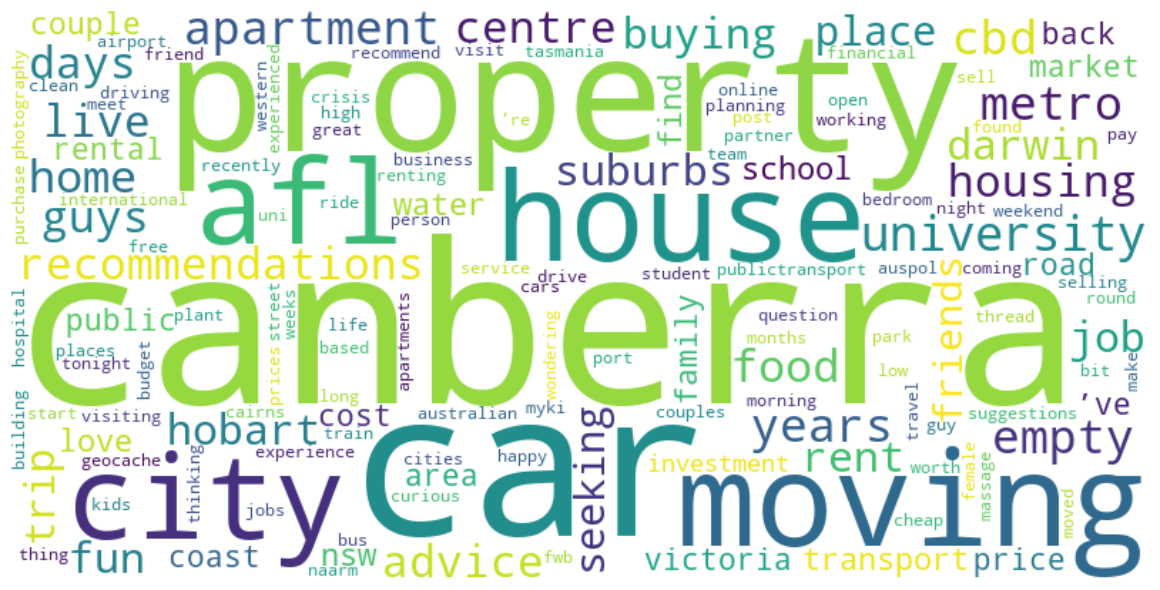

In [7]:
key_cloud()

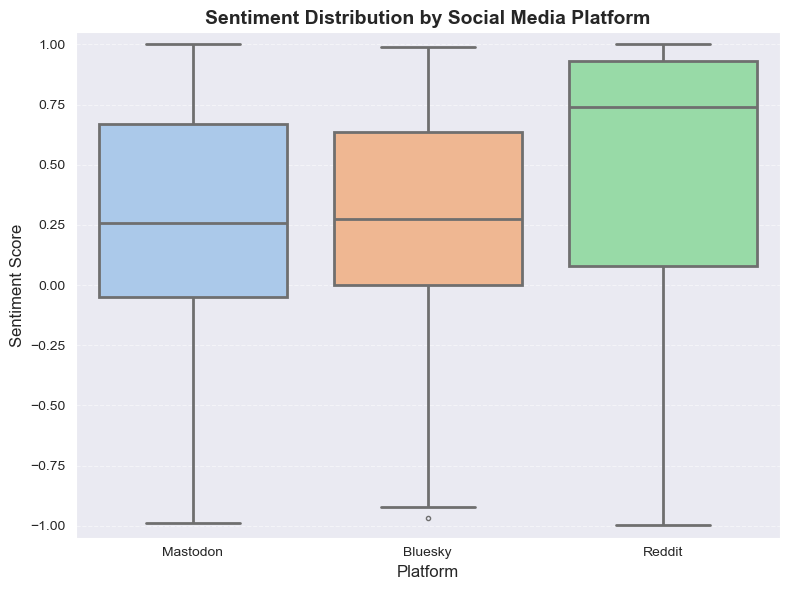

In [8]:
sentimentByPlatform()

In [9]:
extremeKeywords()

,Top 30 Sentiment Keywords,Bottom 30 Sentiment Keywords
1,time,police
2,enjoy,car
3,love,darwin
4,things,man
5,person,daniher
6,online,forward
7,interested,street
8,seeking,hills
9,coast,crime
10,friends,australian


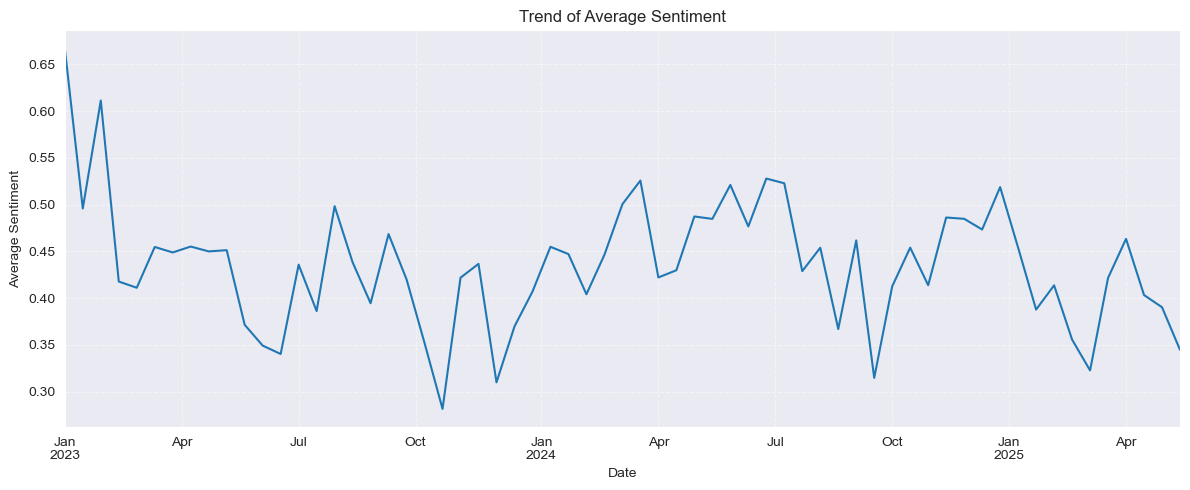

In [10]:
sentimentTrend()

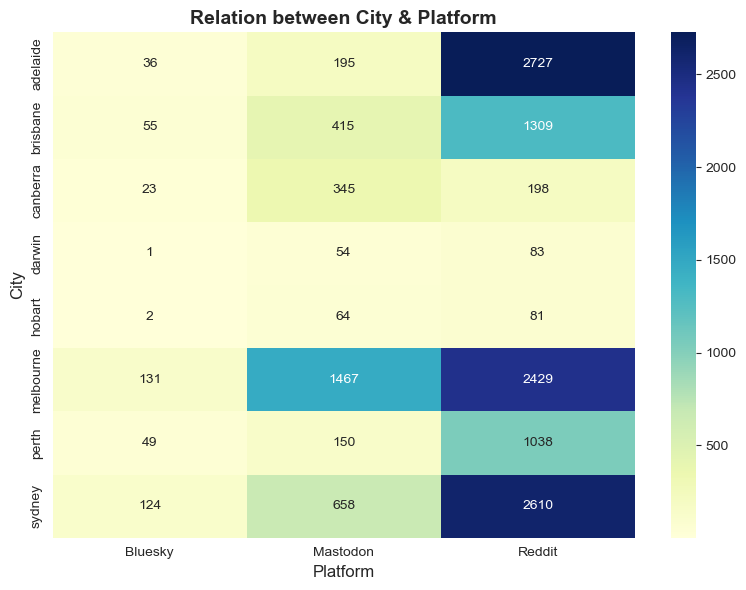

In [11]:
heatMap()

# AFL


In [12]:
afl_related_terms = [
    "afl", "AFL", "afl*", "footy", "footy*", "aflmatch", "aflfinal", 
    "aflfans", "aflteam", "aflgame", "aflnews", "aflclub", "aflround", 
    "afldebate", "aflgrandfinal", "australian football", "aussie rules", 
    "aflw", "aflplayers", "aflscore", "afllive", "afltalk", "aflstats", "aflumpires"
]

afl_payload = {
    "content": afl_related_terms,
    "tags": afl_related_terms,
    "keywords": afl_related_terms,
    "combine": "or",
    "size": 10000,
    "max_docs": 500000,
    "date_range": {
        "from": "01-01-2000",
        "to":   "31-12-2026"
    }
}
#catching the posts has keywords or tags in the list about afl

afl_df = post_processing(afl_payload)
afl_teams_aliases = {
    "Adelaide Crows": ["Adelaide", "Crows", "The Crows", "Ades"],
    "Brisbane Lions": ["Brisbane", "Lions", "Brissie", "The Lions"],
    "Carlton": ["Carlton", "Blues", "The Blues"],
    "Collingwood Magpies": ["Collingwood", "Magpies", "Pies", "The Pies"],
    "Essendon Bombers": ["Essendon", "Bombers", "Dons", "The Bombers"],
    "Fremantle Dockers": ["Fremantle", "Dockers", "Freo", "The Dockers"],
    "Geelong Cats": ["Geelong", "Cats", "The Cats"],
    "Gold Coast Suns": ["Gold Coast", "Suns", "The Suns"],
    "GWS Giants": ["GWS", "Giants", "Greater Western Sydney", "The Giants"],
    "Hawthorn Hawks": ["Hawthorn", "Hawks", "The Hawks"],
    "Melbourne Demons": ["Melbourne", "Demons", "Dees", "The Demons"],
    "North Melbourne Kangaroos": ["North Melbourne", "Kangaroos", "Roos", "The Roos"],
    "Port Adelaide Power": ["Port Adelaide", "Power", "The Power", "Port"],
    "Richmond Tigers": ["Richmond", "Tigers", "The Tigers"],
    "St Kilda Saints": ["St Kilda", "Saints", "The Saints"],
    "Sydney Swans": ["Sydney", "Swans", "The Swans"],
    "West Coast Eagles": ["West Coast", "Eagles", "The Eagles"],
    "Western Bulldogs": ["Western Bulldogs", "Bulldogs", "Doggies", "The Bulldogs"]
}#team names

def detect_afl_teams(row):
    tags = row.get("tags", [])
    keywords = row.get("keywords", [])
 
    if isinstance(tags, str):
        tags = [tags]
    if isinstance(keywords, str):
        keywords = [keywords]
    
    combined = [str(x).lower() for x in tags + keywords]
    matched_teams = []

    for team, aliases in afl_teams_aliases.items():
        for alias in aliases:
            if alias.lower() in combined:
                matched_teams.append(team)
                break  
    
    return matched_teams if matched_teams else np.nan

afl_df["matched_teams"] = afl_df.apply(detect_afl_teams, axis=1)#add team name if it match to some team name

afl_df = afl_df[afl_df["matched_teams"].notnull()]
team_sentiment = defaultdict(lambda: {"positive": 0, "neutral": 0, "negative": 0})#only store the posts belong to a team

for _, row in afl_df.iterrows():
    sentiment = str(row["sentimentLabel"]).lower()
    teams = row.get("matched_teams", [])

    if isinstance(teams, str):
        teams = [teams]

    for team in teams:
        if sentiment in team_sentiment[team]:
            team_sentiment[team][sentiment] += 1

all_teams = sorted(set(team for teams in afl_df["matched_teams"].dropna() for team in teams))

def analyze_team(team_name):
    team_df = afl_df[afl_df["matched_teams"].apply(lambda x: team_name in x if isinstance(x, list) else False)]

    if team_df.empty:
        print(f"No data for {team_name}")
        return

    sentiment_counts = Counter(team_df["sentimentLabel"].str.lower())
    labels = ["positive", "neutral", "negative"]
    values = [sentiment_counts.get(l, 0) for l in labels]

    fig, ax = plt.subplots(figsize=(8,8))  

    wedges, texts, autotexts = ax.pie(
        values,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=["green", "yellow", "red"],
        textprops={'fontsize': 12}
    )

    ax.axis('equal')
    ax.set_title(f"Sentiment Distribution for {team_name}", fontsize=14, loc='center')  
    fig.subplots_adjust(left=0.2, right=0.8)  

    plt.show()

def afl_heat_map():
    exploded = afl_df.explode("matched_teams")
    exploded = exploded[exploded["matched_teams"].notnull()]

    exploded["sentimentLabel"] = exploded["sentimentLabel"].str.lower()
    valid = exploded[exploded["sentimentLabel"].isin(["positive", "neutral", "negative"])]

    sentiment_counts = (
        valid.groupby(["matched_teams", "sentimentLabel"])
        .size()
        .unstack(fill_value=0)
    )


    sentiment_ratio = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0).round(2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(sentiment_ratio, cmap="RdYlGn", annot=True, cbar=True)
    plt.title("Sentiment Ratio by AFL Team")
    plt.xlabel("Sentiment")
    plt.ylabel("AFL Team")
    plt.tight_layout()
    plt.show()


Total hits: 365572


In [13]:
interact(analyze_team, team_name=Dropdown(options=all_teams, description="Team:"))

interactive(children=(Dropdown(description='Team:', options=('Adelaide Crows', 'Brisbane Lions', 'Carlton', 'C…

<function __main__.analyze_team(team_name)>

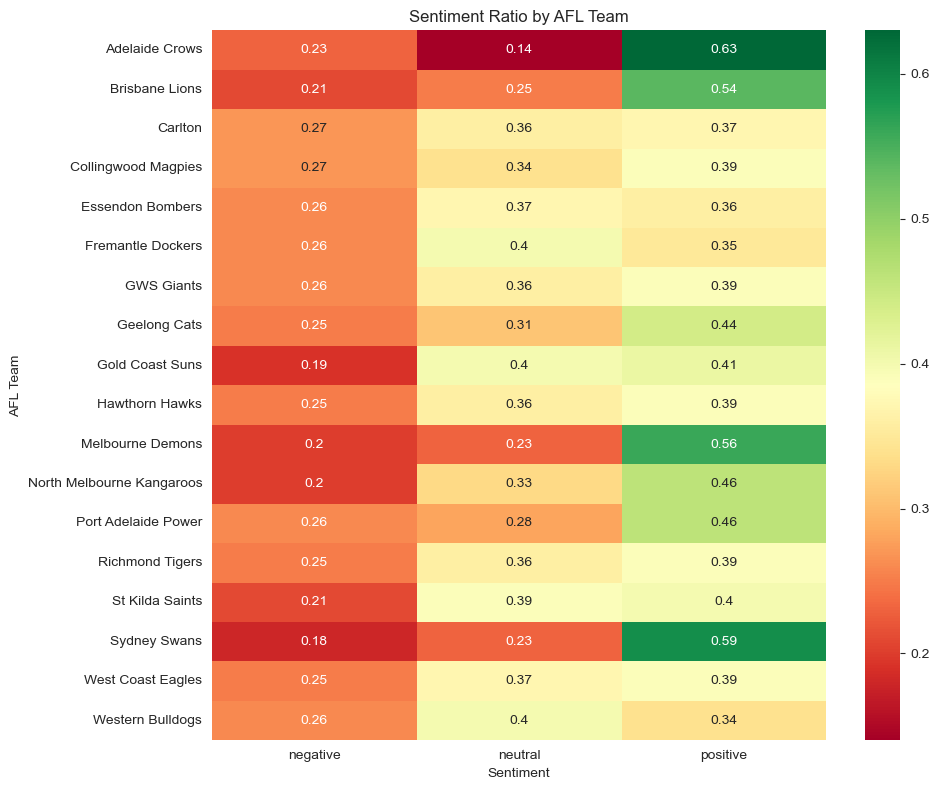

In [14]:
afl_heat_map()